# **DATA SET**
## The Loan Payments dataset from Kaggle contains information about loans, including columns such as loan status, principal, terms, past due days, age, education, and gender. It provides insights into loan payment behavior, defaults, and demographic factors that may influence loan repayment.

## Link: https://www.kaggle.com/code/kolimisneha/loan-data-set/input?select=Loan+payments+data.csv

# **PREDICTION**

## The goal of this model is to predict whether a loan will be paid off or default based on various factors, such as loan status, principal amount, terms, past due days, age, education, and gender. Using classification algorithms, the model aims to accurately classify loans into categories such as "paid off" or "in collection," helping financial institutions assess the risk of loan defaults.

# **GOAL**
## The primary goal is to build a predictive model that can identify loan repayment behavior, particularly predicting defaults. By analyzing demographic and loan-related factors, the model aims to optimize risk management, improve loan approval decisions, and reduce financial losses.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
# --- LOAD DATA ---

data = pd.read_csv('Loan payments data.csv')

data.head()

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


In [3]:
# Data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Loan_ID         500 non-null    object 
 1   loan_status     500 non-null    object 
 2   Principal       500 non-null    int64  
 3   terms           500 non-null    int64  
 4   effective_date  500 non-null    object 
 5   due_date        500 non-null    object 
 6   paid_off_time   400 non-null    object 
 7   past_due_days   200 non-null    float64
 8   age             500 non-null    int64  
 9   education       500 non-null    object 
 10  Gender          500 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 43.1+ KB


In [4]:
# --- FEATURE ENGINEERING ---
# Encode loan_status
status_mapping = {'PAIDOFF': 0, 'COLLECTION': 1, 'COLLECTION_PAIDOFF': 2}
data['loan_status_encoded'] = data['loan_status'].map(status_mapping)

 # Fill missing past_due_days with 0
data['past_due_days'] = data['past_due_days'].fillna(0)

# Target variable
data['paid_off'] = data['loan_status'].apply(lambda x: 1 if x == 'PAIDOFF' else 0)

# Drop unnecessary columns
data = data.drop(['Loan_ID', 'loan_status', 'paid_off_time', 'effective_date', 'due_date'], axis=1)

data.head()


,Principal,terms,past_due_days,age,education,Gender,loan_status_encoded,paid_off
0,1000,30,0.0,45,High School or Below,male,0,1
1,1000,30,0.0,50,Bechalor,female,0,1
2,1000,30,0.0,33,Bechalor,female,0,1
3,1000,15,0.0,27,college,male,0,1
4,1000,30,0.0,28,college,female,0,1



Outliers Visualized Using Box Plots:


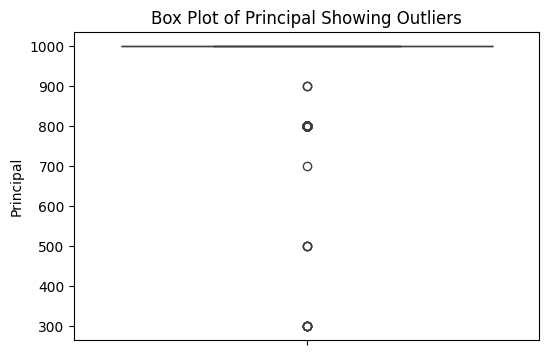

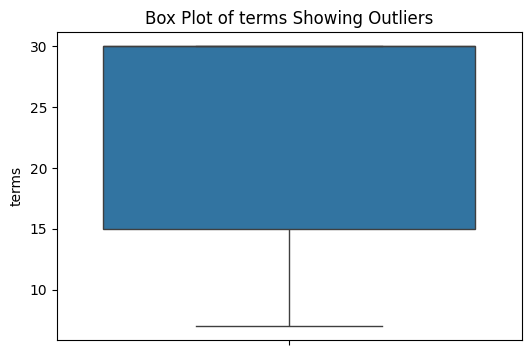

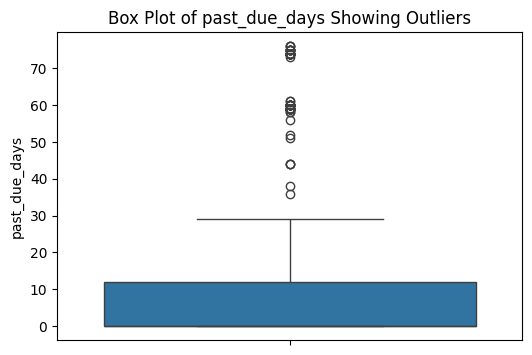

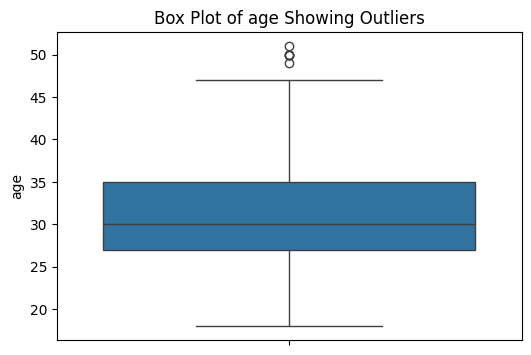

In [5]:
# --- HANDLING OUTLIERS ---

numerical_columns = ['Principal', 'terms', 'past_due_days', 'age']

print("\nOutliers Visualized Using Box Plots:")
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot of {col} Showing Outliers')
    plt.ylabel(col)
    plt.show()

def handle_outliers(column):
    lower_limit = column.quantile(0.05)
    upper_limit = column.quantile(0.95)
    column = np.where(column < lower_limit, lower_limit, column)
    column = np.where(column > upper_limit, upper_limit, column)
    return column

for col in numerical_columns:
    data[col] = handle_outliers(data[col])

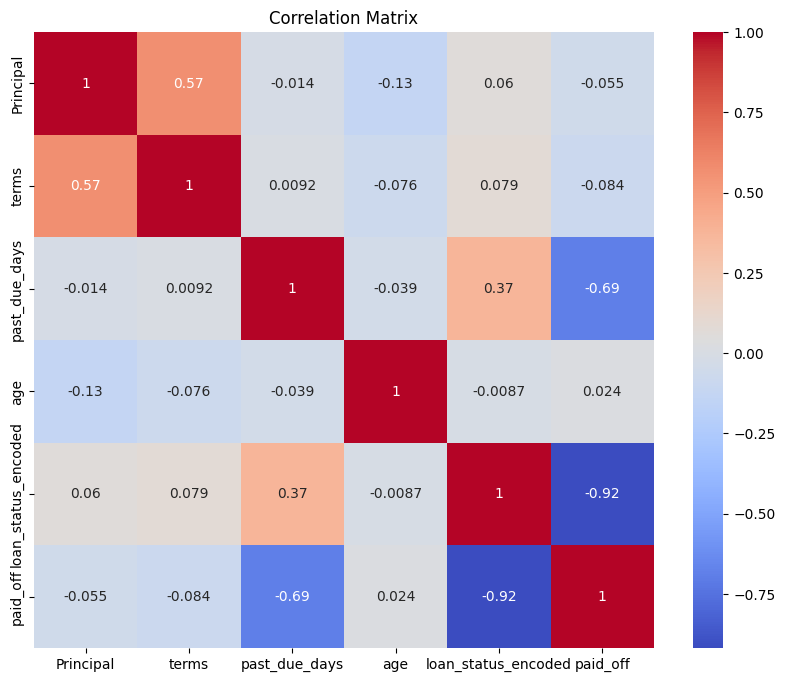

In [6]:
# --- CORRELATION ANALYSIS ---
# Select numerical features for correlation analysis
numerical_features = data.select_dtypes(include=np.number).columns
correlation_matrix = data[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [7]:
# --- MODEL BUILDING ---
# Features
X = data.drop(['loan_status_encoded', 'paid_off'], axis=1)

# Target variable
y = data['loan_status_encoded']

# Convert categorical columns to numerical
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# --- HANDLE CLASS IMBALANCE USING SMOTE ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **SUPPORT VECTOR MACHINES ALGORITHM (SVM)**

In [8]:
# Create a SVM pipeline with scaling and SVM
SVM_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=42))  # SVM with class weights
])

# Perform hyperparameter tuning
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear']
}

grid = GridSearchCV(SVM_pipeline, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            random_state=42))]),
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': [1, 0.1, 0.01, 0.001],
                         'svm__kernel': ['rbf', 'linear']},
             scoring='f1_macro')

In [9]:
print("SVC Report:")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Evaluate the best model on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# --- CROSS-VALIDATION ---
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

SVC Report:
Best parameters: {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Best cross-validation score: 0.9438241524900551
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.94      0.95      0.94        61
           2       0.95      0.90      0.92        59

    accuracy                           0.95       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.95      0.95      0.95       180

Cross-validation Accuracy Scores: [0.92777778 0.93888889 0.96111111 0.96666667 0.96666667]
Mean Accuracy: 0.9522


# **GRADIENT BOOSTING MACHINES ALGORITHM (GBM)**

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a pipeline with scaling and GBM
GBM_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('gbm', GradientBoostingClassifier(random_state=42))  # Gradient Boosting Machines
])

# Perform hyperparameter tuning
param_grid = {
    'gbm__n_estimators': [100, 200, 300],
    'gbm__learning_rate': [0.01, 0.1, 0.2],
    'gbm__max_depth': [3, 5, 7]
}

grid = GridSearchCV(GBM_pipeline, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbm',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gbm__learning_rate': [0.01, 0.1, 0.2],
                         'gbm__max_depth': [3, 5, 7],
                         'gbm__n_estimators': [100, 200, 300]},
             scoring='f1_macro')

In [11]:
print("GBM Report:")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Evaluate the best model on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# --- CROSS-VALIDATION ---
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

GBM Report:
Best parameters: {'gbm__learning_rate': 0.01, 'gbm__max_depth': 7, 'gbm__n_estimators': 100}
Best cross-validation score: 0.9861050783647272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.97      0.98        61
           2       0.97      1.00      0.98        59

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Cross-validation Accuracy Scores: [0.98888889 0.96666667 1.         0.99444444 0.99444444]
Mean Accuracy: 0.9889


# **NAIVE BAYES ALGORITHM**

In [12]:
from sklearn.naive_bayes import GaussianNB
# Create a pipeline with scaling and Naive Bayes
NB_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('nb', GaussianNB())  # Naive Bayes Classifier
])

# Train the pipeline
NB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('nb', GaussianNB())])

In [13]:
print("NAIVE BAYES Report:")
# Evaluate the model on the test set
y_pred = NB_pipeline.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# --- CROSS-VALIDATION ---
cv_scores = cross_val_score(NB_pipeline, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

NAIVE BAYES Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.94      0.95      0.94        61
           2       0.95      0.93      0.94        59

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180

Cross-validation Accuracy Scores: [0.97777778 0.95555556 0.97222222 0.97222222 0.96111111]
Mean Accuracy: 0.9678


# **ADABOOST ALGORITHM**

In [14]:
from sklearn.ensemble import AdaBoostClassifier
# Create a pipeline with scaling and AdaBoost
adaboot_pipeline = Pipeline([
       ('scaler', StandardScaler()),
       ('ab', AdaBoostClassifier(algorithm='SAMME', random_state=42))
   ])

# Train the pipeline
adaboot_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ab', AdaBoostClassifier(algorithm='SAMME', random_state=42))])

In [15]:
print("ADABOOST ALGORITHM Report:")
# Evaluate the model on the test set
y_pred = adaboot_pipeline.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# --- CROSS-VALIDATION ---
cv_scores = cross_val_score(adaboot_pipeline, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

ADABOOST ALGORITHM Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.98      0.99        61
           2       0.98      1.00      0.99        59

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Cross-validation Accuracy Scores: [0.97777778 0.95555556 0.98333333 0.96666667 1.        ]
Mean Accuracy: 0.9767


# **STOCHASTIC GRADIENT DESCENT ALGORITHM (SGD)**

In [16]:
from sklearn.linear_model import SGDClassifier
# Create a pipeline with scaling and SGD
SGB_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('sgd', SGDClassifier(random_state=42))  # Stochastic Gradient Descent Classifier
])

# Train the pipeline
SGB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(random_state=42))])

In [17]:
print("SGD Report:")

# Evaluate the model on the test set
y_pred = SGB_pipeline.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# --- CROSS-VALIDATION ---
cv_scores = cross_val_score(SGB_pipeline, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

SGD Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.81        60
           1       0.92      0.97      0.94        61
           2       0.75      0.80      0.77        59

    accuracy                           0.84       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.84      0.84       180

Cross-validation Accuracy Scores: [0.77222222 0.91666667 0.9        0.86666667 0.88333333]
Mean Accuracy: 0.8678


# **BAGGING CLASSIFIER ALGORITHM**

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a pipeline with scaling and Bagging Classifier
baggibg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42))
])

# Train the pipeline
baggibg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('bagging',
                 BaggingClassifier(estimator=DecisionTreeClassifier(),
                                   random_state=42))])

In [19]:
print("BAGGING CLASSIFIER ALGORITHM Report:")

# Evaluate the model on the test set
y_pred = baggibg_pipeline.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# --- CROSS-VALIDATION ---
cv_scores = cross_val_score(baggibg_pipeline, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

BAGGING CLASSIFIER ALGORITHM Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.98      0.99        61
           2       0.98      1.00      0.99        59

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Cross-validation Accuracy Scores: [0.98888889 0.96666667 1.         0.99444444 1.        ]
Mean Accuracy: 0.9900


# **MULTI-LAYER PERCEPTRON ALGORITHM (MLP)**

In [20]:
from sklearn.neural_network import MLPClassifier

# Create a pipeline with scaling and MLP classifier
MLP_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=42, max_iter=500, early_stopping=True))
])

# Perform hyperparameter tuning
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01]
}

grid = GridSearchCV(MLP_pipeline, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp',
                                        MLPClassifier(early_stopping=True,
                                                      max_iter=500,
                                                      random_state=42))]),
             param_grid={'mlp__activation': ['relu', 'tanh', 'logistic'],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(50,), (100,), (100, 100)],
                         'mlp__solver': ['adam', 'sgd']},
             scoring='f1_macro')

In [21]:
print("MLP Report:")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Evaluate the best model on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# --- CROSS-VALIDATION ---
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

MLP Report:
Best parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 100), 'mlp__solver': 'adam'}
Best cross-validation score: 0.7496826709478451
              precision    recall  f1-score   support

           0       0.73      0.82      0.77        60
           1       0.98      0.95      0.97        61
           2       0.74      0.68      0.71        59

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.82      0.82      0.82       180

Cross-validation Accuracy Scores: [0.73888889 0.67777778 0.85       0.8        0.79444444]
Mean Accuracy: 0.7722


# **RIDGE CLASSIFIER**

In [22]:
from sklearn.linear_model import RidgeClassifier

# Create a Ridge Classifier pipeline with scaling
Ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('ridge', RidgeClassifier(class_weight='balanced', random_state=42))
])

# Perform hyperparameter tuning
param_grid = {
    'ridge__alpha': [0.1, 1, 10],  # Regularization strength
    'ridge__max_iter': [1000, 2000],  # Maximum number of iterations
}

grid = GridSearchCV(Ridge_pipeline, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        RidgeClassifier(class_weight='balanced',
                                                        random_state=42))]),
             param_grid={'ridge__alpha': [0.1, 1, 10],
                         'ridge__max_iter': [1000, 2000]},
             scoring='f1_macro')

In [23]:
print("Ridge Classifier Report:")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Evaluate the best model on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# --- CROSS-VALIDATION ---
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

Ridge Classifier Report:
Best parameters: {'ridge__alpha': 0.1, 'ridge__max_iter': 1000}
Best cross-validation score: 0.6552666766116816
              precision    recall  f1-score   support

           0       0.55      0.77      0.64        60
           1       0.91      1.00      0.95        61
           2       0.53      0.27      0.36        59

    accuracy                           0.68       180
   macro avg       0.67      0.68      0.65       180
weighted avg       0.67      0.68      0.66       180

Cross-validation Accuracy Scores: [0.65       0.66111111 0.70555556 0.70555556 0.65      ]
Mean Accuracy: 0.6744


# Result summary

## Summarizing all models' performances in the table below

|Model                          |Loan status        | f1-score| accuracy|
|-------------------------------|-------------------|---------|---------|
|SUPPORT VECTOR MACHINES (SVM)  |                   |         |0.9522   |
|                               |PAIDOFF            |0.98     |         |
|                               |COLLECTION         |0.94     |         |
|                               |COLLECTION_PAIDOFF |0.92     |         |
|-------------------------------|-------------------|---------|---------|
|GRADIENT BOOSTING MACHINE (GBM)|                   |         |0.9889   |
|                               |PAIDOFF            |1.00     |         |
|                               |COLLECTION         |0.98     |         |
|                               |COLLECTION_PAIDOFF |0.98     |         |
|-------------------------------|-------------------|---------|---------|
|NAIVE BAYES ALGORITHM          |                   |         |0.9678   |
|                               |PAIDOFF            |1.00     |         |
|                               |COLLECTION         |0.94     |         |
|                               |COLLECTION_PAIDOFF |0.94     |         |
|-------------------------------|-------------------|---------|---------|
|ADABOOST ALGORITHM             |                   |         |0.9767   |
|                               |PAIDOFF            |1.00     |         |
|                               |COLLECTION         |0.99     |         |
|                               |COLLECTION_PAIDOFF |0.99     |         |
|-------------------------------|-------------------|---------|---------|

|Model                          |Loan status        | f1-score| accuracy|
|-------------------------------|-------------------|---------|---------|
|STOCHASTIC GRADIENT DESCENT    |                   |         |0.8678   |
|                               |PAIDOFF            |0.81     |         |
|                               |COLLECTION         |0.94     |         |
|                               |COLLECTION_PAIDOFF |0.77     |         |
|-------------------------------|-------------------|---------|---------|
|BAGGING CLASSIFIER             |                   |         |0.9900   |
|                               |PAIDOFF            |1.00     |         |
|                               |COLLECTION         |0.99     |         |
|                               |COLLECTION_PAIDOFF |0.99     |         |
|-------------------------------|-------------------|---------|---------|
|MULTI-LAYER PERCEPTRON (MLP)   |                   |         |0.7722   |
|                               |PAIDOFF            |0.77     |         |
|                               |COLLECTION         |0.97     |         |
|                               |COLLECTION_PAIDOFF |0.71     |         |
|-------------------------------|-------------------|---------|---------|
|RIDGE CLASSIFIER               |                   |         |0.6744   |
|                               |PAIDOFF            |0.64     |         |
|                               |COLLECTION         |0.95     |         |
|                               |COLLECTION_PAIDOFF |0.36     |         |
|-------------------------------|-------------------|---------|---------|

# **CONCLUSION**

## In conclusion, of this models which are evaluated to predict loan repayment behavior, with the goal of identifying defaults based on factors like loan status, principal amount, terms, and demographic information. The performance of these models was measured using F1-scores and accuracy for different loan statuses ("paid off" and "in collection").
## Among the models, Gradient Boosting Machine (GBM) outperformed the others with the highest F1-score of 0.9889 and perfect accuracy for "paid off" loans, demonstrating its excellent ability to classify loan repayment behavior. Bagging Classifier also performed exceptionally well, achieving an F1-score of 0.9900 with high accuracy across all categories, making it a strong contender for predicting loan outcomes. Naive Bayes, AdaBoost, and Support Vector Machines (SVM) also showed robust performance, with F1-scores above 0.95, offering a good balance of accuracy and precision.
## On the other hand, Ridge Classifier exhibited the lowest F1-score (0.6744), particularly underperforming for the "collection_paidoff" category. Multi-Layer Perceptron (MLP) and Stochastic Gradient Descent also demonstrated weaker performance, especially with the "paid off" classification, indicating that these models may not be the best fit for this particular problem.
## Overall, GBM and Bagging Classifier emerged as the top models, offering reliable predictions for loan repayment status, which could significantly enhance risk management strategies and loan approval decisions in financial institutions.